In [19]:
# Standard Library Imports
import os
import re
import time
import multiprocessing

# Third Party Imports
import pprint
from glob import glob
import numpy as np
import webbpsf
from astropy.io import fits
from astropy.io import ascii as asc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Local Imports (from nircam_simulator package)
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator, write_observationlist
from mirage.catalogs import get_catalog
from mirage.psf import psf_library

# View matplotlib plots inline
%matplotlib inline

In [2]:
# Where the pointing and XML file for this particular OTE CAR are located
ote_dir = '/user/lchambers/OTECommSims/OTE06-1140_withPSFs/'

# Where the output FITS files will be saved to
library_root_dir = '/user/lchambers/OTECommSims/test_library_output/'

---
# First, generate (fake) PSF library files

Let's simulate Image Array 1 (OTE-06).
It has 6 observations:
- The first 5 observations are WFSC Commissioning observations, that each include 18 WFC groups. (18 sets of image-move-image. Right?)
- The last observation is simply NIRCam imaging to see how we did.

So I will need 5 x 18 = 90 distinct PSF library files. 

### Define location of APT files and catalogs

In [3]:
prop_id = 1140

# Change if you named your files differently.
root = 'OTE06-1140'

pointing_file = os.path.join(ote_dir, 'OTE06-1140.pointing')
xml_file = os.path.join(ote_dir, 'OTE06-1140.xml')

In [4]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

Target coordinates:  146.87731 63.24781
Shortwave catalog file 2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.


### Get the observation/visit information from the APT files

In [5]:
# Get the information from the pointing file
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, '1140')
n_exposures = len(pointing_tab['visit_id'])

In [6]:
print('You will be writing out {} individual FITS files.'.format(len(pointing_tab['visit_id'])))

You will be writing out 99 individual FITS files.


In [77]:
# Create dictionary that mirrors the program structure
program_structure = {}
for i in range(n_exposures):
    obs_num = pointing_tab['obs_num'][i]
    visit_num = pointing_tab['visit_num'][i]
    activity_id = pointing_tab['act_id'][i]
    
    obs_key = 'Observation{}'.format(obs_num)
    visit_key = 'Visit{}'.format(visit_num)
    
    program_structure.setdefault(obs_key, {})
    visit_dict = program_structure[obs_key].setdefault(visit_key, []).append('Activity{}'.format(activity_id))                                                                      
    
pprint.pprint(program_structure)  

{'Observation001': {'Visit001': ['Activity01',
                                 'Activity02',
                                 'Activity03',
                                 'Activity04',
                                 'Activity05',
                                 'Activity06',
                                 'Activity07',
                                 'Activity08',
                                 'Activity09',
                                 'Activity0a',
                                 'Activity0b',
                                 'Activity0c',
                                 'Activity0d',
                                 'Activity0e',
                                 'Activity0f',
                                 'Activity0g',
                                 'Activity0h',
                                 'Activity0i',
                                 'Activity0j']},
 'Observation002': {'Visit001': ['Activity0k',
                                 'Activity0l',
           

In [8]:
# Create directory structure based on dictionary

psf_paths = []
program_dir = os.path.join(library_root_dir, root)
for observation in program_structure.keys():
    for visit in program_structure[observation].keys():
        for activity in program_structure[observation][visit]:
            activity_dir = os.path.join(program_dir, observation, visit, activity)
            if not os.path.exists(activity_dir):
                os.makedirs(activity_dir)
            psf_paths.append(activity_dir)

## Generate the original PSF array

In [24]:
# Generate original PSF

# Let's go for a global alignment-esque thing, with the image array and random pistons.
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

# Set up the array
webbpsf.opds.setup_image_array(ote, reset=True, verbose=False, size='large', )

# Add random pistons
random_pistons = np.random.randn(18)*500  # substantial coarse phasing erorrs. 
for i, seg in enumerate(ote.segnames[0:18]):  # don't piston "segment 19" the SM
    ote.move_seg_local(seg, piston=random_pistons[i])

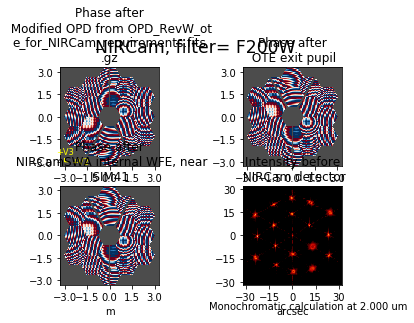

In [8]:
original_psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_pixels=2048, display=True)

## Make slightly different PSFs for every exposure

In [29]:
def create_lib_for_random_ote(i):
    start_time = time.time()
    obs = 'Observation{}'.format(pointing_tab['obs_num'][i])
    visit = 'Visit{}'.format(pointing_tab['visit_num'][i])
    visit_dir = os.path.join(program_dir, obs, visit)
    
    print('Calculating PSF for obs {}, visit {}, exposure {}'
          .format(pointing_tab['obs_num'][i], pointing_tab['visit_num'][i], i + 1))

    i_seg = random_segments[i]
    ote.move_seg_local(ote.segnames[i_seg], piston = random_pistons[i])

    library_filename = 'nircam_f212n_fovp2048_samp1_npsf1_exp{}.fits'.format(i + 1)
    c = psf_library.CreatePSFLibrary('NIRCam', filters='F212N', detectors='NRCA3', 
                                     fov_pixels=2048, oversample=1, num_psfs=1, 
                                     fileloc=visit_dir, filename=library_filename,
                                     pupil_opd=ote, overwrite=False)
    c.create_files()
    
    print('Elapsed time: {}\n'.format(time.time() - start_time))

In [15]:
# Define a beep noise
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)

In [26]:
# Determine how many cores I have
multiprocessing.cpu_count()

32

<div class="alert alert-warning">
**Attention!** 
<br>
Note that the following cell is meant to be executed on `telserv1`, which has 32 processors! If you run it on your own machine, bad and unpredictable things may happen. Be careful to use fewer processors than are on your computer. 
</div>

In [ ]:
# Generate PSF library files for each exposure - WITH MULTIPROCESSING!:
n_exposures = len(pointing_tab['visit_id'])

random_segments = np.random.randint(0, 17, n_exposures)
random_pistons = np.random.randn(n_exposures)*500

p = multiprocessing.Pool(30)
p.map(create_lib_for_random_ote, range(n_exposures))
    
beep(5)

---
# Next, actually do MIRAGE simulations with these different PSFs

## Generate YAML files

In [20]:
# Create observation table file from APT files
observationlist_file = os.path.join(os.getcwd(), ote_dir, root + '_observationlist.yaml')
write_observationlist.write_yaml(xml_file, pointing_file, observationlist_file, 
                                 ps_cat_sw=catalog_filenames_sw, ps_cat_lw=catalog_filenames_lw)

Found 19 exposure(s) for observation 1 (Form medium array)
Found 19 exposure(s) for observation 2 (Clean up or form large array)
Found 19 exposure(s) for observation 3 (Form large array or clean up)
Found 19 exposure(s) for observation 4 (Clean up large array)
Found 19 exposure(s) for observation 5 (Clean up large array)
Found 4 exposure(s) for observation 6 (NIRCam Image Segments)

Successfully wrote 6 observations to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140_withPSFs_observationlist.yaml


In [21]:
# Create a series of data simulator input yaml files from APT files
yam = yaml_generator.SimInput()

yam.input_xml = xml_file
yam.pointing_file = pointing_file
siaf_file = os.path.expandvars('$MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv')
yam.siaf = siaf_file
yam.output_dir = os.path.join(os.getcwd(), ote_dir)
yam.simdata_output_dir = os.path.join(os.getcwd(), ote_dir)
yam.observation_table = observationlist_file

# *** THIS IS THE PART WHERE WE MODIFY THE PSF ***
yam.psf_paths = psf_paths

yam.use_JWST_pipeline = False # changed to False
yam.use_linearized_darks = True # changed to True
yam.datatype = 'linear'

yam.reffile_setup()
yam.create_inputs()

Using /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140_withPSFs_observationlist.yaml, 
      /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140.xml, 
      /user/lchambers/OTECommSims/OTE06-1140_withPSFs/OTE06-1140.pointing, and 
      /ifs/jwst/wit/mirage_data/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv 
      to generate observation table.

Found 19 exposure(s) for observation 1 (Form medium array)
Found 19 exposure(s) for observation 2 (Clean up or form large array)
Found 19 exposure(s) for observation 3 (Form large array or clean up)
Found 19 exposure(s) for observation 4 (Clean up large array)
Found 19 exposure(s) for observation 5 (Clean up large array)
Found 4 exposure(s) for observation 6 (NIRCam Image Segments)
Wrote exposure table to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/expand_for_detectors.csv
Final csv exposure list written to /user/lchambers/OTECommSims/OTE06-1140_withPSFs/Observation_table_for_OTE06-1140.xml.csv
Using provided PSF p

## Do the simulations!

In [9]:
# Get all the NRCA3 yamls
all_yaml_files = glob(ote_dir + 'jw*nrca3.yaml')
n_yamls = len(all_yaml_files)
print(n_yamls)

99


In [10]:
def simulate_image_from_yaml(i):
    yaml = all_yaml_files[i]
    print('*** SIMULATING YAML {}/{}: {} ***'.format(i+1, n_yamls, yaml))
    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = yaml
    img_sim.create()

<div class="alert alert-warning">
**Attention!** 
<br>
Note that the following cell is meant to be executed on `telserv1`, which has 32 processors! If you run it on your own machine, bad and unpredictable things may happen. Be careful to use fewer processors than are on your computer. 
</div>

In [ ]:
# Generate simulated NIRCam images of each exposure - WITH MULTIPROCESSING!:
p = multiprocessing.Pool(30)
p.map(simulate_image_from_yaml, range(n_yamls))  

## Just for fun: Examine the location of the target in different exposures

In [7]:
import pysiaf

Example files for each pointing:
--------------------------------
1. jw01140004001_0111t_00001
9. jw01140006001_0112p_00001
24. jw01140006001_0112q_00001
45. jw01140006001_0112o_00001
60. jw01140006001_0112r_00001


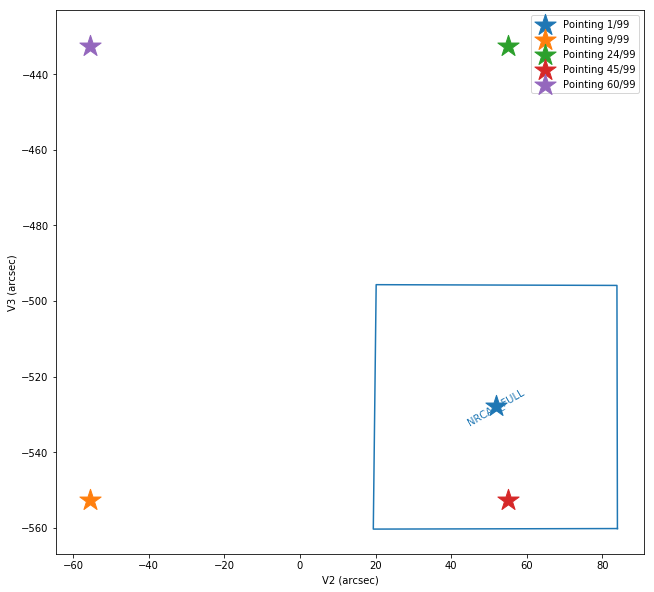

In [8]:
# Examine NRCA3 aperture
nc_siaf = pysiaf.Siaf('NIRCam')

plt.figure(figsize=(15,10))
nc_siaf['NRCA3_FULL'].plot(frame='tel', name_label=True, fill_color='white')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, '1140')
all_pointings = set([(v2, v3, obs_id) for v2, v3, obs_id in zip(pointing_tab['v2'], 
                                                                pointing_tab['v3'], 
                                                                pointing_tab['observation_id'])])
# print(all_pointings)

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, obs_id) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, obs_id))

plt.legend()

plt.show()